In [1]:
import os
from mat4py import loadmat
import h5py
import tables
import mat73
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [2]:
data1 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_1766/'
data2 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_7671532/'
data3 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_15332298/'
data4 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_22993064/'

In [3]:
# Read the data

patient_ids = []
images = []
labels = []
tumorBorders = []
tumorMask = []

def populate_lists(data1):
    for d in os.listdir(data1):
        mat = mat73.loadmat(data1 + d)
        patient_ids.append(mat['cjdata']['PID'])
        images.append(mat['cjdata']['image'])
        labels.append(int(mat['cjdata']['label']))
        tumorBorders.append(mat['cjdata']['tumorBorder'])
        tumorMask.append(mat['cjdata']['tumorMask'])
    return patient_ids, images, labels, tumorBorders, tumorMask

patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data1)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data2)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data3)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data4)

In [4]:
patient_ids[0]

'100360'

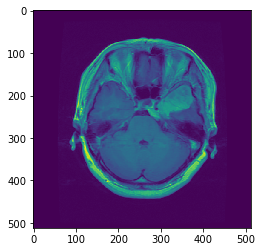

In [5]:
plt.imshow(images[0])

In [6]:
labels[0]

1

In [7]:
tumorBorders[0]

array([267.61524501, 231.37568058, 277.83666062, 248.10163339,
       289.91651543, 250.8892922 , 305.71324864, 253.676951  ,
       318.72232305, 249.9600726 , 321.50998185, 237.88021779,
       354.96188748, 234.16333938, 367.97096189, 227.65880218,
       380.9800363 , 210.93284936, 372.61705989, 195.13611615,
       363.32486388, 177.48094374, 350.31578947, 176.55172414,
       336.37749546, 183.98548094, 317.79310345, 196.06533575,
       305.71324864, 207.21597096, 295.49183303, 217.43738657,
       288.98729583, 222.08348457, 273.19056261, 223.94192377,
       268.54446461, 228.58802178])

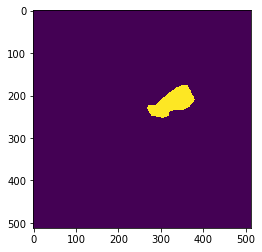

In [8]:
plt.imshow(tumorMask[0])

In [9]:
# Exploratory Analysis on Data

# Number of total samples
print('Number of total samples: ' + str(len(patient_ids)))

# Number of unique patients
print('Number of unique patients we have samples for: ' + str(len(set(patient_ids))))

# What are the unique class labels
print('Unique Class Labels: ' + str(set(labels)))

# Frequency of class labels
print('Frequency Class Labels: ' + str({x:labels.count(x) for x in labels}))
print('Class 1 is Meningioma, Class 2 is Glioma, Class 3 is Pituitary Tumor')

Number of total samples: 3064
Number of unique patients we have samples for: 233
Unique Class Labels: {1, 2, 3}
Frequency Class Labels: {1: 708, 2: 1426, 3: 930}
Class 1 is Meningioma, Class 2 is Glioma, Class 3 is Pituitary Tumor


In [10]:
# What do the individual tumors look like?

ind_1 = []
ind_2 = []
ind_3 = []

for ind in range(len(labels)):
    if labels[ind] == 1:
        ind_1.append(ind)
    elif labels[ind] == 2:
        ind_2.append(ind)
    else:
        ind_3.append(ind)

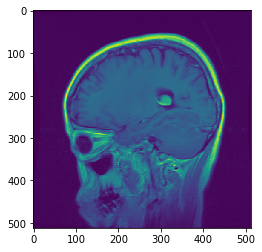

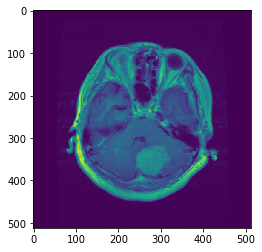

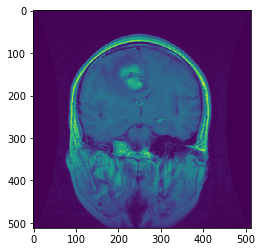

In [11]:
# Label 1 Samples

for i in random.sample(ind_1, 3):
    plt.figure()
    plt.imshow(images[i])

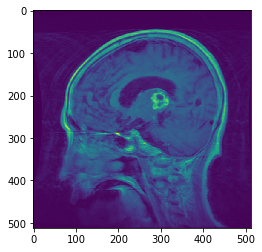

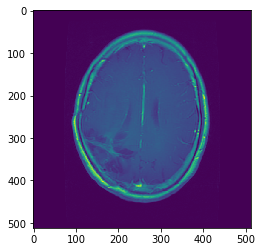

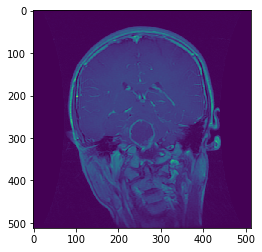

In [12]:
# Label 2 Samples

for i in random.sample(ind_2, 3):
    plt.figure()
    plt.imshow(images[i])

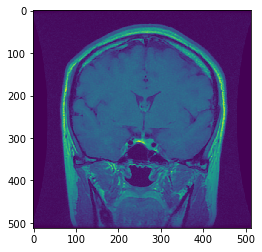

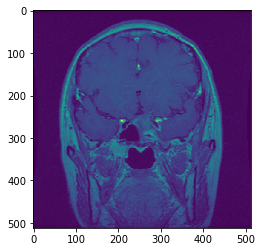

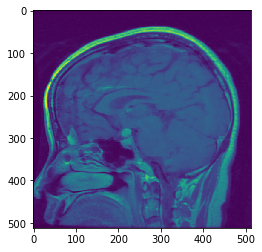

In [13]:
# Label 3 Samples

for i in random.sample(ind_3, 3):
    plt.figure()
    plt.imshow(images[i])

No identifiable differences between the tumor classes so we rely on the supervised model to classify these optimally.

In [ ]:
# Length of the tumor border
for i in tumorBorders:
    print(len(i))
    
# We need to convert these borders to bounding boxes since the tumor borders are not uniform
bounding_boxes = []
for i in tumorMask:
    left_boundary = np.where(i.astype(int).sum(axis = 0) > 0)[0][0]
    right_boundary = np.where(i.astype(int).sum(axis = 0) > 0)[0][-1]
    top_boundary = np.where(i.astype(int).sum(axis = 1) > 0)[0][0]
    bottom_boundary = np.where(i.astype(int).sum(axis = 1) > 0)[0][-1]

In [ ]:
np.where(tumorMask[0].astype(int).sum(axis = 0) > 0)[0]

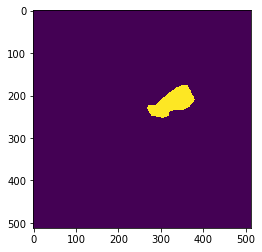

In [14]:
plt.imshow(tumorMask[0])

In [15]:
# Shape of images to ensure uniformity
shapes = []
for i in images:
    shapes.append(i.shape[0])

sum(shapes)/len(shapes)
# Not all are the same sizes

510.7467362924282

# Data Processing

In [16]:
# Resizing Images - we can use this as a hyperparameter but for now, let's construct 128x128 pixel images from those we have

width = 128
height = 128

resized_images = []

for i in images:
    resized_images.append(cv2.resize(i, (width, height), interpolation=cv2.INTER_LINEAR))

images = resized_images.copy()

In [17]:
# We can increase the number of samples by created denoised versions of the existing images using a Gaussian blur
# The tumor location does not change so we don't have to worry about fixing the border.

denoised_images = []

# We can use kernel shape as hyperparameter but for now, fixing to (11, 11)
denoising_kernel = (11, 11)

for i in images:
    denoised_images.append(cv2.GaussianBlur(i, denoising_kernel, 0))

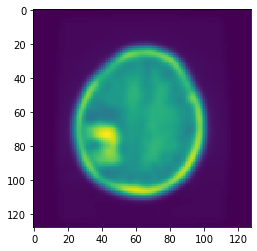

In [18]:
plt.imshow(denoised_images[10])

In [19]:
# We can further remove noise by segmenting the image using thresholding, with 128 as threshold. 
# But first, we should normalize the pixel values in each image from 0 to 255

seg_images = []

for i in denoised_images:
    temp = cv2.normalize(i, i, 0, 255, cv2.NORM_MINMAX)
    seg_images.append(cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)[1])

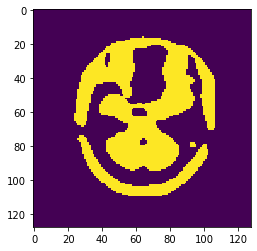

In [20]:
plt.imshow(seg_images[0])

In [21]:
# Let's also create some additional data - rotational, translational transformations

translation_images = []
rot_images = []

for i in images:
    translation_images.append(cv2.warpAffine(i, 
                                          np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]]), 
                                          (i.shape[1], i.shape[0])))
    rot_images.append(ndimage.rotate(i, random.randint(1, 359), reshape = False))

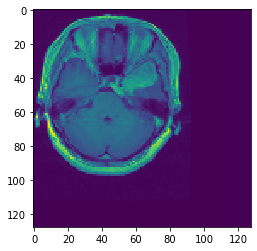

In [22]:
plt.imshow(translation_images[0])

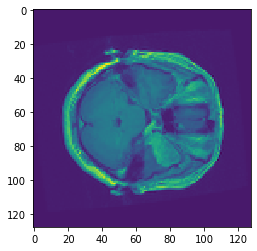

In [23]:
plt.imshow(rot_images[0])

In [33]:
# Finalize which data to use for to build and test the classifier - keep changing to see effect of different preprocessing steps

final = images.copy()
final_labels = labels.copy()

In [43]:
# Split into train and test - use 70% for training and 30% for test

train_test_split = 0.7

# Get indices of each class
ind_1 = []
ind_2 = []
ind_3 = []

for ind in range(len(final_labels)):
    if final_labels[ind] == 1:
        ind_1.append(ind)
    elif final_labels[ind] == 2:
        ind_2.append(ind)
    else:
        ind_3.append(ind)

# Get 70% for each of the classes
def get_train_test(class_list, train_test_split, final, final_labels):
    train = []
    test = []
    train_y = []
    test_y = []
    
    train_indices = random.sample(class_list, int(np.round(len(class_list)*train_test_split)))
    test_indices = list(set(class_list) - set(train_indices))
    
    for ind in range(len(final)):
        if ind in train_indices:
            train.append(final[ind])
            train_y.append(final_labels[ind])
        elif ind in test_indices:
            test.append(final[ind])
            test_y.append(final_labels[ind])
    return train, test, train_y, test_y

class_1_res = get_train_test(ind_1, train_test_split, final, final_labels)
class_2_res = get_train_test(ind_2, train_test_split, final, final_labels)
class_3_res = get_train_test(ind_3, train_test_split, final, final_labels)

# Keep Changing Train data adding more preprocessing steps
# I am replicating class 1 and class 3 samples so that during training, they are the same as class 2
train = class_1_res[0]*5 + class_2_res[0] + class_3_res[0]*3 + denoised_images + seg_images
train_y = class_1_res[2]*5 + class_2_res[2] + class_3_res[2]*3 + labels + labels

test = class_1_res[1] + class_2_res[1] + class_3_res[1]
test_y = class_1_res[3] + class_2_res[3] + class_3_res[3]

# Scale train and test images from 0 to 1, reshape
for t in range(len(train)):
    temp = train[t]
    temp = temp/255
    train[t] = temp.reshape(temp.shape[0], temp.shape[1], 1)
for t in range(len(test)):
    temp = test[t]
    temp = temp/255
    test[t] = temp.reshape(temp.shape[0], temp.shape[1], 1)

In [44]:
# Quality check
print(len(train) == len(train_y))
print(len(test) == len(test_y))

print({x: train_y.count(x) for x in set(train_y)})
print({x: test_y.count(x) for x in set(test_y)})

True
True
{1: 3896, 2: 3850, 3: 3813}
{1: 212, 2: 428, 3: 279}


In [45]:
# Shuffle training data

def shuffle_lists(list1, list2):
    c = list(zip(list1, list2))
    random.shuffle(c)
    list1, list2 = zip(*c)
    return list(list1), list(list2)

train, train_y = shuffle_lists(train, train_y)
test, test_y = shuffle_lists(test, test_y)

# Convert target arrays into binary arrays
train_y = to_categorical(train_y)[:, 1:]
test_y = to_categorical(test_y)[:, 1:]

In [46]:
# Define the model

def cnn_model(n_nodes_hidden, n_hidden_layers, kernel_size = (3, 3), image_shape = (width, height, 1)):
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size, activation = 'relu', input_shape = image_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    for h in range(n_hidden_layers):
        model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_nodes_hidden, activation='relu'))
    model.add(layers.Dense(3, activation = 'softmax'))
    
    return model, model.summary()

model, model_summary = cnn_model(64, 3)
model_summary

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 12, 64)       

In [ ]:
# Fit baseline model

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
fit_model = model.fit(np.array(train), train_y, epochs = 10, verbose = True)

In [ ]:
# Accuracy of baseline model on test data

model.evaluate(np.array(test), test_y)

In [ ]:
# We want to calculate precision, recall, f1 score per class for train and test

pred_probability_train = model.predict_proba(np.array(train))
predictions_train = np.argmax(pred_probability_train, axis = 1) + 1
actuals_train = np.argmax(train_y, axis = 1) + 1

pred_probability_test = model.predict_proba(np.array(test))
predictions_test = np.argmax(pred_probability_test, axis = 1) + 1
actuals_test = np.argmax(test_y, axis = 1) + 1

for cl in [1, 2, 3]:
    print('Train & Test Precision for class ' + str(cl))
    train_precision = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(predictions_train) if x == cl])
    print(train_precision)
    test_precision = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(predictions_test) if x == cl])
    print(test_precision)
    
    print('Train & Test Recall for class ' + str(cl))
    train_recall = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(actuals_train) if x == cl])
    print(train_recall)
    test_recall = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(actuals_test) if x == cl])
    print(test_recall)
    
    print('Train & Test F1 Score for class ' + str(cl))
    train_f1 = (2*train_precision*train_recall)/(train_precision + train_recall)
    print(train_f1)
    test_f1 = (2*test_precision*test_recall)/(test_precision + test_recall)
    print(test_f1)
    print('\n')

In [47]:
# Now let's automate the process and generate the metrics with hyperparameter tuning

metrics_df = pd.DataFrame()

hidden_nodes_list = [64, 32]
hidden_layers_list = [3, 2, 1]

for i in hidden_nodes_list:
    for j in hidden_layers_list:
        model, model_summary = cnn_model(i, j)
        
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        model.fit(np.array(train), train_y, epochs = 5, verbose = True)
        
        train_acc = model.evaluate(np.array(train), train_y)[1]
        test_acc = model.evaluate(np.array(test), test_y)[1]
        
        # Compile all important information in 1 dataframe
        per_model_df = pd.DataFrame({'n_nodes_hidden': i,
                                     'n_hidden_layers': j,
                                     'acc_train': train_acc,
                                     'acc_test': test_acc}, index = [0])
        
        # We want to calculate precision, recall, f1 score per class for train and test

        pred_probability_train = model.predict_proba(np.array(train))
        predictions_train = np.argmax(pred_probability_train, axis = 1) + 1
        actuals_train = np.argmax(train_y, axis = 1) + 1

        pred_probability_test = model.predict_proba(np.array(test))
        predictions_test = np.argmax(pred_probability_test, axis = 1) + 1
        actuals_test = np.argmax(test_y, axis = 1) + 1
        
        for cl in [1, 2, 3]:
            train_precision = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(predictions_train) if x == cl])
            per_model_df['train_' + str(cl) + '_prec'] = [train_precision]
            test_precision = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(predictions_test) if x == cl])
            per_model_df['test_' + str(cl) + '_prec'] = [test_precision]

            train_recall = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(actuals_train) if x == cl])
            per_model_df['train_' + str(cl) + '_rec'] = [train_recall]
            test_recall = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(actuals_test) if x == cl])
            per_model_df['test_' + str(cl) + '_rec'] = [test_recall]

            train_f1 = (2*train_precision*train_recall)/(train_precision + train_recall)
            per_model_df['train_' + str(cl) + '_f1'] = [train_f1]
            test_f1 = (2*test_precision*test_recall)/(test_precision + test_recall)
            per_model_df['test_' + str(cl) + '_f1'] = [test_f1]
        
        metrics_df = metrics_df.append(per_model_df)
        print('Done')

metrics_df

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 12, 12, 64)       

Train on 11559 samples
Epoch 1/5
11559/11559 [==============================] - 95s 8ms/sample - loss: 0.6902 - accuracy: 0.7059
Epoch 2/5
11559/11559 [==============================] - 94s 8ms/sample - loss: 0.4435 - accuracy: 0.8146
Epoch 3/5
11559/11559 [==============================] - 89s 8ms/sample - loss: 0.3187 - accuracy: 0.8703
Epoch 4/5
11559/11559 [==============================] - 90s 8ms/sample - loss: 0.2292 - accuracy: 0.9083
Epoch 5/5
919/919 [==============================] - 2s 2ms/sample - loss: 0.5507 - accuracy: 0.8672
Done
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)          

,n_nodes_hidden,n_hidden_layers,acc_train,acc_test,train_1_prec,test_1_prec,train_1_rec,test_1_rec,train_1_f1,test_1_f1,...,train_2_rec,test_2_rec,train_2_f1,test_2_f1,train_3_prec,test_3_prec,train_3_rec,test_3_rec,train_3_f1,test_3_f1
0,64,3,0.984168,0.943417,0.973062,0.848101,0.982803,0.948113,0.977908,0.895323,...,0.969870,0.915888,0.976209,0.944578,0.997123,0.978571,1.000000,0.982079,0.998560,0.980322
0,64,2,0.981313,0.961915,0.961664,0.897321,0.985113,0.948113,0.973247,0.922018,...,0.964935,0.948598,0.974171,0.960947,0.999736,0.996403,0.993968,0.992832,0.996844,0.994614
0,64,1,0.960983,0.926007,0.907386,0.797619,0.993326,0.948113,0.948413,0.866379,...,0.899481,0.878505,0.945400,0.923833,0.988738,0.975089,0.990034,0.982079,0.989385,0.978571
0,32,3,0.941171,0.867247,0.913636,0.688172,0.928645,0.905660,0.921079,0.782077,...,0.895844,0.761682,0.923427,0.854522,0.958030,0.914754,0.999738,1.000000,0.978439,0.955479
0,32,2,0.974046,0.947769,0.991914,0.915094,0.944559,0.915094,0.967657,0.915094,...,0.992468,0.969626,0.963075,0.951835,0.998406,0.996198,0.985576,0.939068,0.991949,0.966790
0,32,1,0.983563,0.935800,0.969735,0.844156,0.986910,0.919811,0.978247,0.880361,...,0.965714,0.915888,0.977007,0.933333,0.992956,0.989130,0.998164,0.978495,0.995553,0.983784


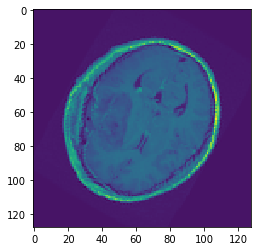

In [31]:
plt.imshow(train[-2][:, :, 0])

In [48]:
metrics_df.to_excel('Raw_Denoise_Seg_Upsample.xlsx', index = False)

# Tumor Localization